In [1]:
import os
os.chdir("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ee
ee.Initialize()
import geemap
print(ee.__version__)

0.1.360


In [2]:
dc = ee.FeatureCollection('TIGER/2018/States').filterMetadata('NAME', 'equals', 'District of Columbia').geometry()

## DMSP

In [3]:
viirs = (ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
                .filterDate('2014-01-01','2022-12-31')
                .select('avg_rad'))
print(f"there are {viirs.size().getInfo()} images in this collection.")

there are 108 images in this collection.


In [4]:
viirsmed = viirs.median()

In [5]:
dcMap = geemap.Map()
dcMap.centerObject(dc, zoom=12)
dcMap.add_basemap('SATELLITE')
dcMap.addLayer(viirsmed.mask(viirsmed).clip(dc), {'min':1,'max':20}, opacity=0.2)
dcMap

Map(center=[38.90475739114548, -77.01628733224862], controls=(WidgetControl(options=['position', 'transparent_…

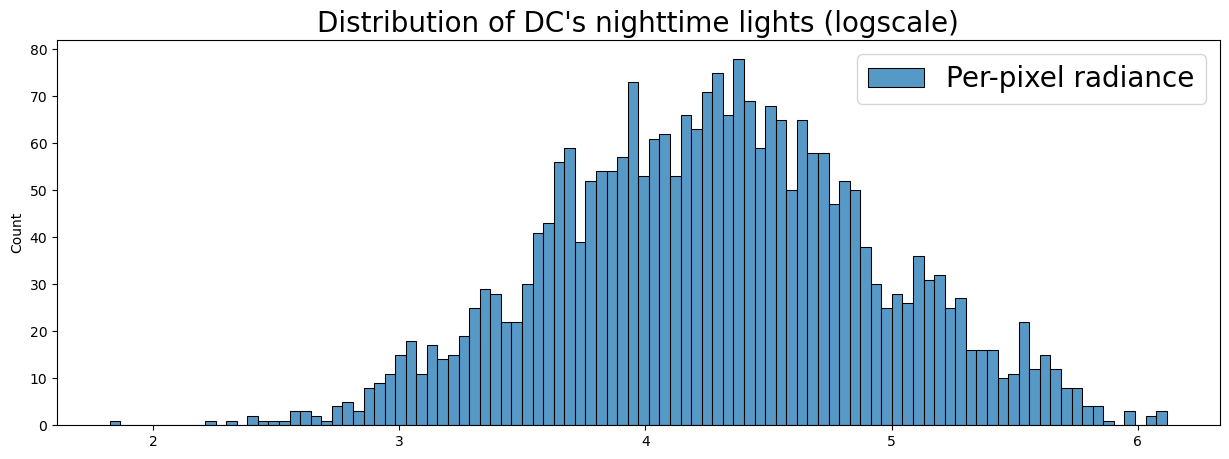

In [7]:
arr = np.array(viirs.first().sampleRectangle(region=dc).get('avg_rad').getInfo())
data = np.log(arr.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data, bins=100, label="Per-pixel radiance", legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title("Distribution of DC's nighttime lights (logscale)", fontsize=20);